In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import os

In [3]:
filenames = [i for i in os.listdir('Data/FLOATMAG_BH_Datalog_2023_10_17 09.37.30 _Samp=8000/') if i.endswith(".dat")]

In [ ]:
#lets have 23 for training and 7 for testing

In [4]:
data = pd.read_csv(f'Data/FLOATMAG_BH_Datalog_2023_10_17 09.37.30 _Samp=8000/{filenames[1]}', delimiter="\t", index_col = "sample")

In [ ]:
# #Information from andrew in the readme:
# 1. Motion profile (sine profile)

# max vel: 195.312 mm/s
# max acc/dec: 2500mm/s^2

# move distance: 0.5mm

# 2. Control BW: 50Hz with damping ratio 0.7

# 3. Objective: design a controller that could be used to compensate endpoint vibration (around 85hz)

# #column information from andrew:

# Notation about the datalog channel information as shown below:

# Sample è time indexing with sampling rate 8000           
# CMD_POS_FLOATMAG_BH      è Motion command
# ENC_POS_FLOATMAG_BH       è Encoder position
# POS_ERR_FLOATMAG_BH       è error between motion command and encoder
# DAC_FLOATMAG_BH                è Related to actuator electrical current
# FLOATMAG_ACC_ADC_PORT_0 è End point acceleration signal being measured with accelerometer

In [ ]:
#ok so the new data is slightly different

# - the encoder data is not in um but I assume we can convert using the same equation as previous:
#ENC_X(um) is calculated by ENC_POS_FLOATMAG_BH*5/1000

# - we no longer actually have endpoint position measurements, instead we have endpoint accelerometer meadurements
#ok so how do we want to proceed? Do we want to calculate position from acceleration as the reference values?
#or do we just want to predict the acceleration values?






In [6]:
data

,CMD_POS_FLOATMAG_BH,ENC_POS_FLOATMAG_BH,POS_ERR_FLOATMAG_BH,DAC_FLOATMAG_BH,MODE_FLOATMAG_BH,FLOATMAG_ACC_ADC_PORT_0
sample,,,,,,
0,-3.0,1.0,0.0,-205.0,ff010001,-223.0
1,-3.0,-3.0,0.0,-183.0,ff010001,41.0
2,-3.0,-1.0,-2.0,-204.0,903000a,-99.0
3,-3.0,1.0,-4.0,-198.0,903000a,131.0
4,-3.0,0.0,-3.0,-169.0,903000a,-96.0
...,...,...,...,...,...,...
13691,-3.0,-1.0,-2.0,-211.0,ff010001,24.0
13692,-3.0,-2.0,-1.0,-199.0,ff010001,64.0
13693,-3.0,-5.0,2.0,-188.0,ff010001,-6.0


In [ ]:
#so reached max position in around 0.06 seconds

Text(0, 0.5, 'Standard Deviation (um)')

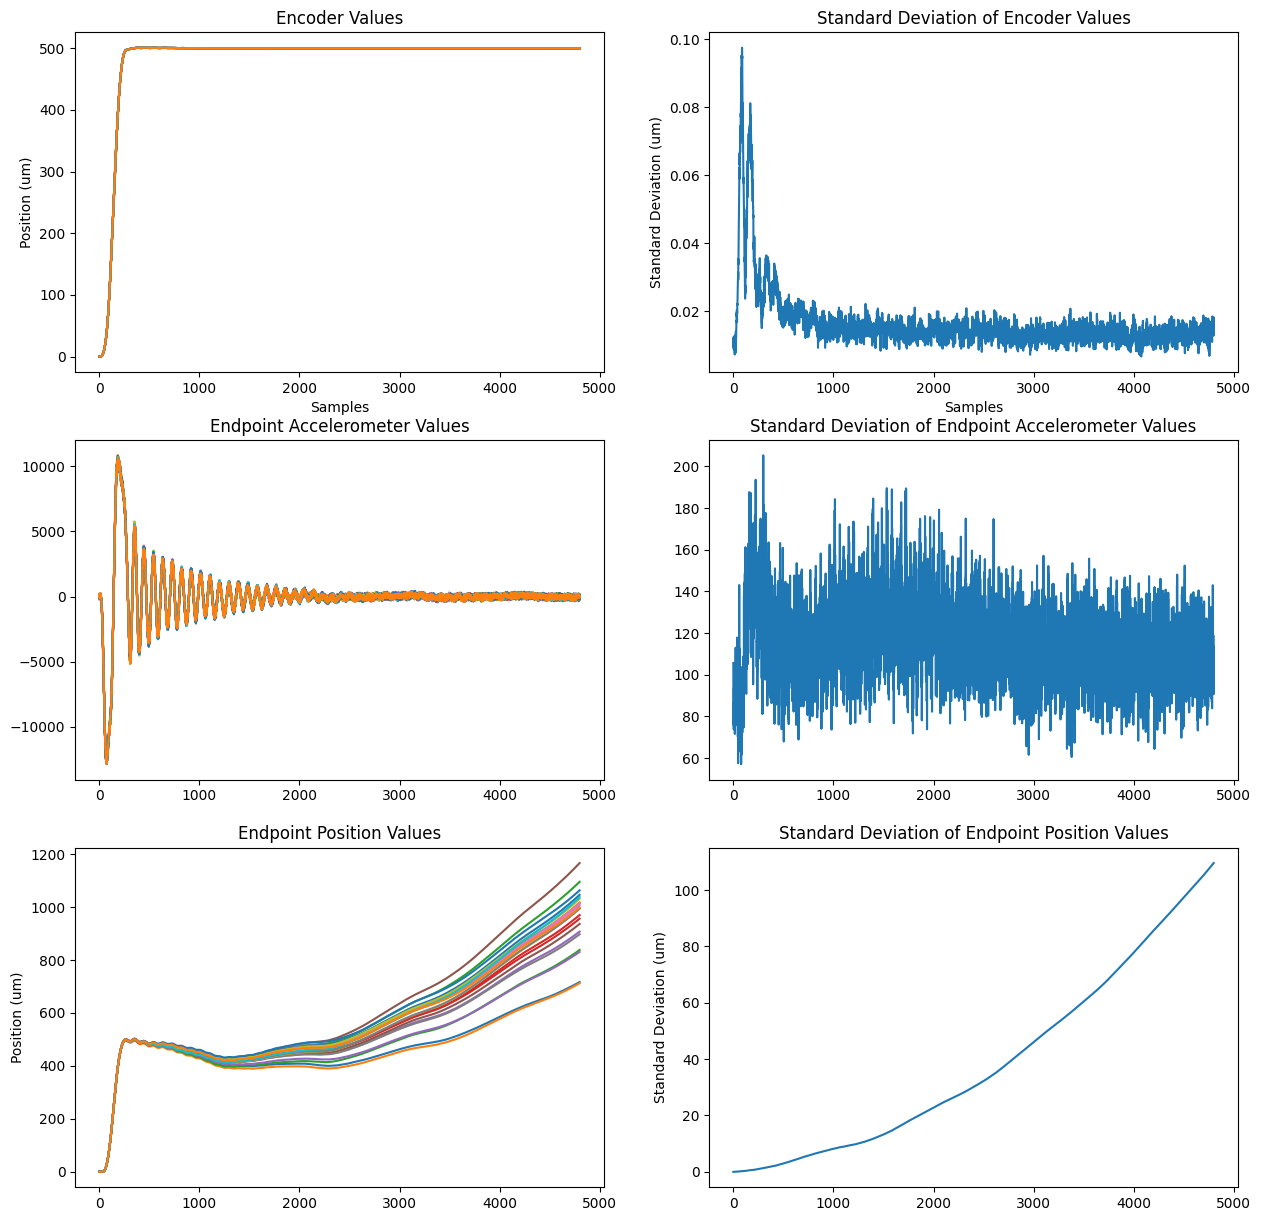

In [5]:
file_lengths = []

for i in range(len(filenames)):

    data = pd.read_csv(f'Data/FLOATMAG_BH_Datalog_2023_10_17 09.37.30 _Samp=8000/{filenames[i]}', delimiter="\t", index_col = "sample")

    file_lengths.append(len(data))

file_lengths = np.array(file_lengths)

n_samples = 4800 #300 is all we need for the motion phase to complete

fix, axs = plt.subplots(3, 2, figsize=(15, 15))

encoder_values = []
endpoint_values = []
endpoint_position_values = []
for i in np.where(file_lengths > n_samples)[0]:

    data = pd.read_csv(f'Data/FLOATMAG_BH_Datalog_2023_10_17 09.37.30 _Samp=8000/{filenames[i]}', delimiter="\t", index_col = "sample")

    axs[0, 0].plot(data["ENC_POS_FLOATMAG_BH"].iloc[:n_samples] / 200)

    encoder_values.append((data["ENC_POS_FLOATMAG_BH"].iloc[:n_samples] / 200).values)

    axs[1, 0].plot(data["FLOATMAG_ACC_ADC_PORT_0"].iloc[:n_samples])

    endpoint_values.append(data["FLOATMAG_ACC_ADC_PORT_0"].iloc[:n_samples].values)

    functional_point_velocity = (-data["FLOATMAG_ACC_ADC_PORT_0"]).expanding().apply(lambda x: np.trapz(x, dx=1/8000))
    functional_point_position = (functional_point_velocity).expanding().apply(lambda x: np.trapz(x, dx=1/8000)).values * 269.4 #multiplying by 269.4 to convert to um (on the assumption that max position is 500 um)

    axs[2,0].plot(functional_point_position[:n_samples])
    endpoint_position_values.append(functional_point_position[:n_samples])


encoder_values = np.array(encoder_values)
endpoint_values = np.array(endpoint_values)
endpoint_position_values = np.array(endpoint_position_values)

axs[0,1].plot(np.std(encoder_values, axis=0))
# axs[0,1].plot(pd.Series(np.std(encoder_values, axis=0)).ewm(span=75).mean().values, "r")
# axs[0,1].plot(pd.Series(np.std(encoder_values, axis=0)).rolling(window=30).mean().values, "g")


axs[0,1].set_title("Standard Deviation of Encoder Values")
axs[0,1].set_ylabel("Standard Deviation (um)")
axs[0,1].set_xlabel("Samples")

axs[0,0].set_title("Encoder Values")
axs[0,0].set_ylabel("Position (um)")
axs[0,0].set_xlabel("Samples")

axs[1,0].set_title("Endpoint Accelerometer Values")

axs[1,1].plot(np.std(endpoint_values, axis=0))
axs[1,1].set_title("Standard Deviation of Endpoint Accelerometer Values")


axs[2,0].set_title("Endpoint Position Values")
axs[2,0].set_ylabel("Position (um)")


axs[2,1].plot(np.std(endpoint_position_values, axis=0))
axs[2,1].set_title("Standard Deviation of Endpoint Position Values")
axs[2,1].set_ylabel("Standard Deviation (um)")






Text(0.5, 0, 'Time (s)')

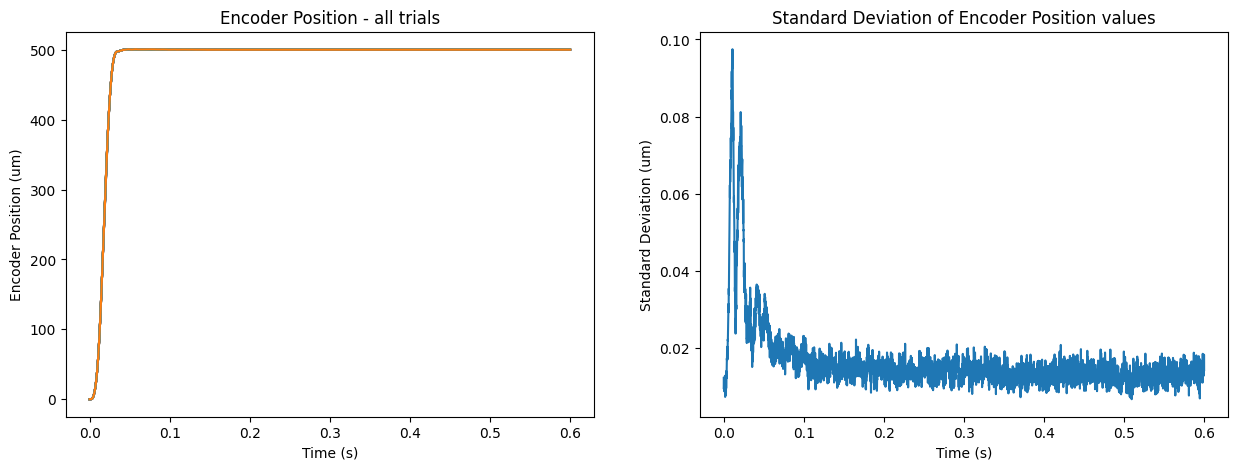

In [46]:
fix, axs = plt.subplots(1, 2, figsize=(15, 5))

encoder_values = []
endpoint_values = []
endpoint_position_values = []

times = np.array(list(range(4800))) / 8000

for i in np.where(file_lengths > n_samples)[0]:

    data = pd.read_csv(f'Data/FLOATMAG_BH_Datalog_2023_10_17 09.37.30 _Samp=8000/{filenames[i]}', delimiter="\t", index_col = "sample")

    axs[0].plot(times, data["ENC_POS_FLOATMAG_BH"].iloc[:n_samples] / 200)

    encoder_values.append((data["ENC_POS_FLOATMAG_BH"].iloc[:n_samples] / 200).values)

    # axs[1, 0].plot(data["FLOATMAG_ACC_ADC_PORT_0"].iloc[:n_samples])

    # endpoint_values.append(data["FLOATMAG_ACC_ADC_PORT_0"].iloc[:n_samples].values)

    # functional_point_velocity = (-data["FLOATMAG_ACC_ADC_PORT_0"]).expanding().apply(lambda x: np.trapz(x, dx=1/8000))
    # functional_point_position = (functional_point_velocity).expanding().apply(lambda x: np.trapz(x, dx=1/8000)).values * 269.4 #multiplying by 269.4 to convert to um (on the assumption that max position is 500 um)

    # axs[2,0].plot(functional_point_position[:n_samples])
    # endpoint_position_values.append(functional_point_position[:n_samples])


encoder_values = np.array(encoder_values)
# endpoint_values = np.array(endpoint_values)
# endpoint_position_values = np.array(endpoint_position_values)

axs[1].plot(times, np.std(encoder_values, axis=0))


axs[1].set_title("Standard Deviation of Encoder Position values")
axs[1].set_ylabel("Standard Deviation (um)")
axs[1].set_xlabel("Time (s)")

axs[0].set_title("Encoder Position - all trials")
axs[0].set_ylabel("Encoder Position (um)")
axs[0].set_xlabel("Time (s)")

# ax2 = axs[1].twinx()
# ax2.plot(times, (np.max(encoder_values, axis = 0) - np.min(encoder_values, axis = 0)), "r")


# axs[0].set_xlim(0.03, 0.1)
# axs[0].set_ylim(480, 520)



In [51]:
import pickle

#pickle the encoder values

with open("encoder_values.pkl", "wb") as f:
    pickle.dump(encoder_values, f)

In [49]:
list(encoder_values)

[array([5.00000e-03, 5.00000e-03, 0.00000e+00, ..., 4.99975e+02,
        5.00000e+02, 5.00000e+02]),
 array([ 5.00000e-03, -1.50000e-02, -1.00000e-02, ...,  4.99960e+02,
         4.99960e+02,  4.99975e+02]),
 array([-2.00000e-02,  0.00000e+00, -2.00000e-02, ...,  4.99955e+02,
         4.99965e+02,  4.99970e+02]),
 array([-1.00000e-02, -5.00000e-03,  5.00000e-03, ...,  4.99975e+02,
         4.99970e+02,  4.99970e+02]),
 array([-1.5000e-02, -1.0000e-02, -1.0000e-02, ...,  4.9998e+02,
         4.9999e+02,  4.9998e+02]),
 array([-1.50000e-02,  0.00000e+00,  0.00000e+00, ...,  5.00000e+02,
         4.99995e+02,  4.99995e+02]),
 array([ 5.00000e-03, -1.50000e-02, -5.00000e-03, ...,  4.99985e+02,
         4.99995e+02,  4.99975e+02]),
 array([-1.00000e-02,  5.00000e-03,  1.00000e-02, ...,  4.99955e+02,
         4.99950e+02,  4.99955e+02]),
 array([ 0.00000e+00, -1.00000e-02, -5.00000e-03, ...,  4.99975e+02,
         4.99995e+02,  4.99980e+02]),
 array([0.00000e+00, 5.00000e-03, 1.50000e-02, ..

In [42]:
def low_pass(array, sampling_rate = 8000, cutoff_frequency = 200):
    from scipy.signal import butter, filtfilt

    # Calculate the Nyquist frequency
    nyquist_frequency = sampling_rate / 2.0

    filter_order = 2  # Second-order filter, can be increased for a steeper roll-off

    normal_cutoff = cutoff_frequency / nyquist_frequency
    b, a = butter(filter_order, normal_cutoff, btype='low', analog=False)

    filtered_array = (filtfilt(b, a, array))

    return filtered_array

Text(0.5, 0, 'Time (s)')

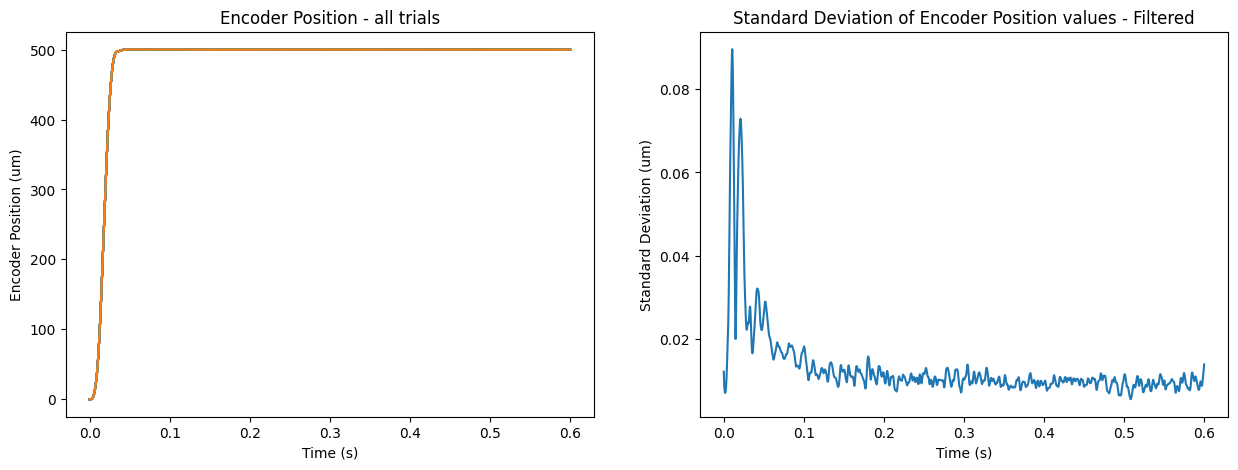

In [53]:
fix, axs = plt.subplots(1, 2, figsize=(15, 5))

encoder_values = []
endpoint_values = []
endpoint_position_values = []

times = np.array(list(range(4800))) / 8000

for i in np.where(file_lengths > n_samples)[0]:

    data = pd.read_csv(f'Data/FLOATMAG_BH_Datalog_2023_10_17 09.37.30 _Samp=8000/{filenames[i]}', delimiter="\t", index_col = "sample")

    data_array = low_pass(data["ENC_POS_FLOATMAG_BH"].iloc[:n_samples], cutoff_frequency=250) / 200

    axs[0].plot(times, data_array)

    encoder_values.append(data_array)

    # axs[1, 0].plot(data["FLOATMAG_ACC_ADC_PORT_0"].iloc[:n_samples])

    # endpoint_values.append(data["FLOATMAG_ACC_ADC_PORT_0"].iloc[:n_samples].values)

    # functional_point_velocity = (-data["FLOATMAG_ACC_ADC_PORT_0"]).expanding().apply(lambda x: np.trapz(x, dx=1/8000))
    # functional_point_position = (functional_point_velocity).expanding().apply(lambda x: np.trapz(x, dx=1/8000)).values * 269.4 #multiplying by 269.4 to convert to um (on the assumption that max position is 500 um)

    # axs[2,0].plot(functional_point_position[:n_samples])
    # endpoint_position_values.append(functional_point_position[:n_samples])


encoder_values = np.array(encoder_values)
# endpoint_values = np.array(endpoint_values)
# endpoint_position_values = np.array(endpoint_position_values)

axs[1].plot(times, np.std(encoder_values, axis=0))


axs[1].set_title("Standard Deviation of Encoder Position values - Filtered")
axs[1].set_ylabel("Standard Deviation (um)")
axs[1].set_xlabel("Time (s)")

axs[0].set_title("Encoder Position - all trials")
axs[0].set_ylabel("Encoder Position (um)")
axs[0].set_xlabel("Time (s)")

# ax2 = axs[1].twinx()
# ax2.plot(times, (np.max(encoder_values, axis = 0) - np.min(encoder_values, axis = 0)), "r")


# axs[0].set_xlim(0.03, 0.1)
# axs[0].set_ylim(480, 520)

In [45]:
encoder_values.shape

(22, 4800)

Text(0.5, 0, 'Time (s)')

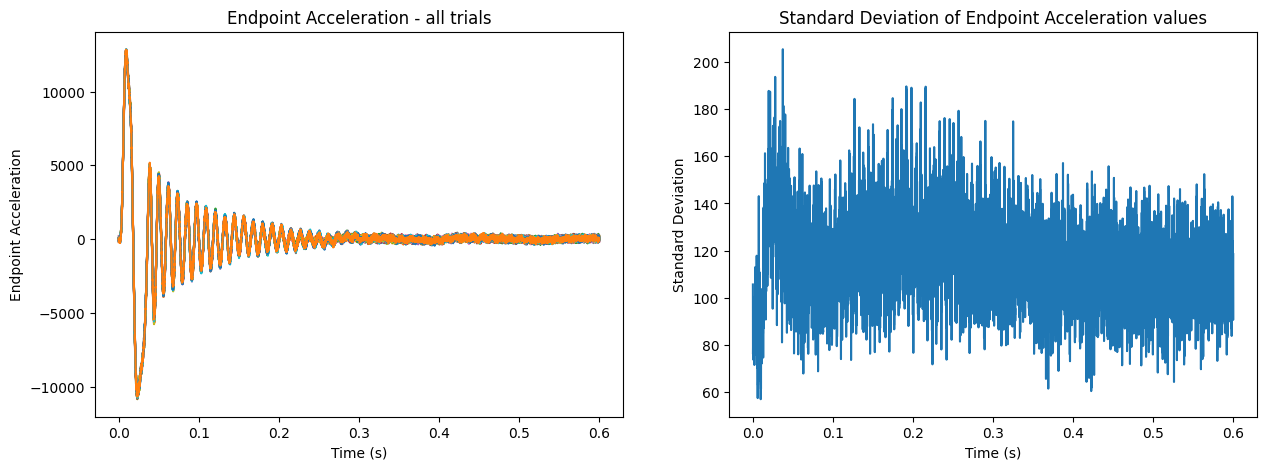

In [68]:
#now doig the same for the accelerometer data

fix, axs = plt.subplots(1, 2, figsize=(15, 5))

encoder_values = []
endpoint_values = []
endpoint_position_values = []

times = np.array(list(range(4800))) / 8000

for i in np.where(file_lengths > n_samples)[0]:

    data = pd.read_csv(f'Data/FLOATMAG_BH_Datalog_2023_10_17 09.37.30 _Samp=8000/{filenames[i]}', delimiter="\t", index_col = "sample")

    # axs[0].plot(times, data["ENC_POS_FLOATMAG_BH"].iloc[:n_samples] / 200)

    # encoder_values.append((data["ENC_POS_FLOATMAG_BH"].iloc[:n_samples] / 200).values)

    axs[0].plot(times, -data["FLOATMAG_ACC_ADC_PORT_0"].iloc[:n_samples])

    endpoint_values.append(-data["FLOATMAG_ACC_ADC_PORT_0"].iloc[:n_samples].values)

    # functional_point_velocity = (-data["FLOATMAG_ACC_ADC_PORT_0"]).expanding().apply(lambda x: np.trapz(x, dx=1/8000))
    # functional_point_position = (functional_point_velocity).expanding().apply(lambda x: np.trapz(x, dx=1/8000)).values * 269.4 #multiplying by 269.4 to convert to um (on the assumption that max position is 500 um)

    # axs[2,0].plot(functional_point_position[:n_samples])
    # endpoint_position_values.append(functional_point_position[:n_samples])


# axs[0].plot(times, np.mean(endpoint_values, axis=0), "r")

# encoder_values = np.array(encoder_values)
endpoint_values = np.array(endpoint_values)
# endpoint_position_values = np.array(endpoint_position_values)

# axs[1].plot(times, np.std(encoder_values, axis=0))
axs[1].plot(times, np.std(endpoint_values, axis=0))


axs[1].set_title("Standard Deviation of Endpoint Acceleration values")
axs[1].set_ylabel("Standard Deviation")
axs[1].set_xlabel("Time (s)")

axs[0].set_title("Endpoint Acceleration - all trials")
axs[0].set_ylabel("Endpoint Acceleration")
axs[0].set_xlabel("Time (s)")

# ax2 = axs[1].twinx()
# ax2.plot(times, (np.max(encoder_values, axis = 0) - np.min(encoder_values, axis = 0)), "r")


# axs[0].set_xlim(0.03, 0.1)
# axs[0].set_ylim(480, 520)

Text(0.5, 0, 'Time (s)')

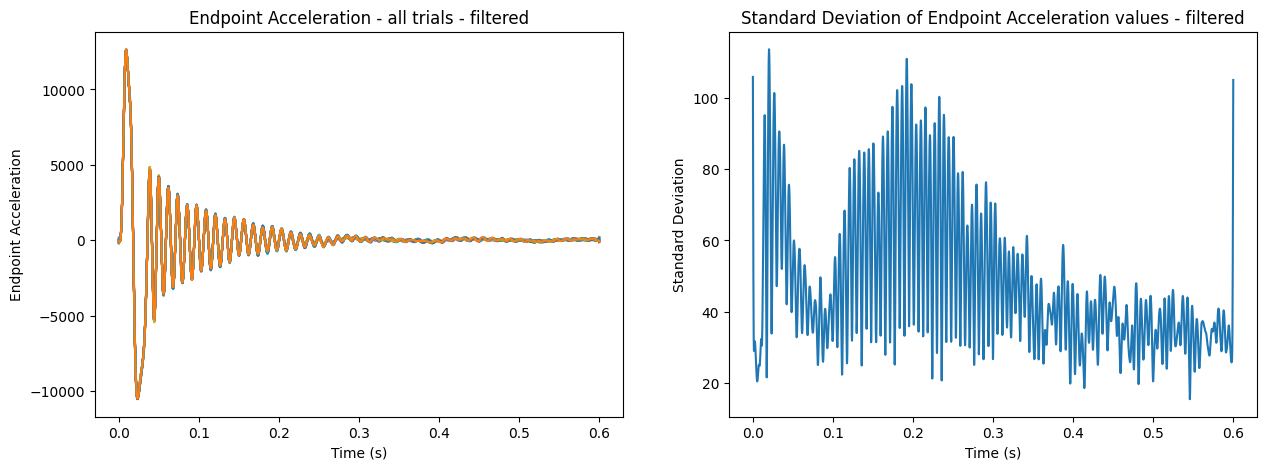

In [83]:
fix, axs = plt.subplots(1, 2, figsize=(15, 5))

encoder_values = []
endpoint_values = []
endpoint_position_values = []

times = np.array(list(range(4800))) / 8000

for i in np.where(file_lengths > n_samples)[0]:

    data = pd.read_csv(f'Data/FLOATMAG_BH_Datalog_2023_10_17 09.37.30 _Samp=8000/{filenames[i]}', delimiter="\t", index_col = "sample")

    # axs[0].plot(times, data["ENC_POS_FLOATMAG_BH"].iloc[:n_samples] / 200)

    # encoder_values.append((data["ENC_POS_FLOATMAG_BH"].iloc[:n_samples] / 200).values)

    data_array = low_pass(-data["FLOATMAG_ACC_ADC_PORT_0"].iloc[:n_samples], cutoff_frequency=250)

    axs[0].plot(times, data_array)

    endpoint_values.append(data_array)

    # functional_point_velocity = (-data["FLOATMAG_ACC_ADC_PORT_0"]).expanding().apply(lambda x: np.trapz(x, dx=1/8000))
    # functional_point_position = (functional_point_velocity).expanding().apply(lambda x: np.trapz(x, dx=1/8000)).values * 269.4 #multiplying by 269.4 to convert to um (on the assumption that max position is 500 um)

    # axs[2,0].plot(functional_point_position[:n_samples])
    # endpoint_position_values.append(functional_point_position[:n_samples])


# encoder_values = np.array(encoder_values)
endpoint_values = np.array(endpoint_values)
# endpoint_position_values = np.array(endpoint_position_values)

# axs[1].plot(times, np.std(encoder_values, axis=0))
axs[1].plot(times, np.std(endpoint_values, axis=0))


axs[1].set_title("Standard Deviation of Endpoint Acceleration values - filtered")
axs[1].set_ylabel("Standard Deviation")
axs[1].set_xlabel("Time (s)")

axs[0].set_title("Endpoint Acceleration - all trials - filtered")
axs[0].set_ylabel("Endpoint Acceleration")
axs[0].set_xlabel("Time (s)")

# ax2 = axs[1].twinx()
# ax2.plot(times, (np.max(encoder_values, axis = 0) - np.min(encoder_values, axis = 0)), "r")


# axs[0].set_xlim(0.03, 0.1)
# axs[0].set_ylim(480, 520)

In [6]:
encoder_values

array([[ 5.00000e-03,  5.00000e-03,  0.00000e+00, ...,  4.99975e+02,
         5.00000e+02,  5.00000e+02],
       [ 5.00000e-03, -1.50000e-02, -1.00000e-02, ...,  4.99960e+02,
         4.99960e+02,  4.99975e+02],
       [-2.00000e-02,  0.00000e+00, -2.00000e-02, ...,  4.99955e+02,
         4.99965e+02,  4.99970e+02],
       ...,
       [-1.50000e-02, -5.00000e-03, -2.00000e-02, ...,  4.99990e+02,
         5.00010e+02,  4.99985e+02],
       [-1.50000e-02, -2.50000e-02, -1.00000e-02, ...,  4.99960e+02,
         4.99955e+02,  4.99950e+02],
       [-5.00000e-03,  5.00000e-03, -5.00000e-03, ...,  4.99970e+02,
         4.99970e+02,  4.99975e+02]])

In [ ]:
#ok so what are we trying to find out?
#what is the consistency between the measurements?

#for the encoder measurements, the maximum std recorded was around 0.1um




#
#
#

In [53]:
endpoint_position_values.mean(axis= 0).max()
#if we assume that the max position for the endpoint is equivelent to 500um, then we need to scale endppoint values by (500 / 1.856) = 269.4 

1.8564151389322916

In [75]:
data = pd.read_csv(f'Data/FLOATMAG_BH_Datalog_2023_10_17 09.37.30 _Samp=8000/{filenames[15]}', delimiter="\t", index_col = "sample")

Text(0.5, 0, 'Time (s)')

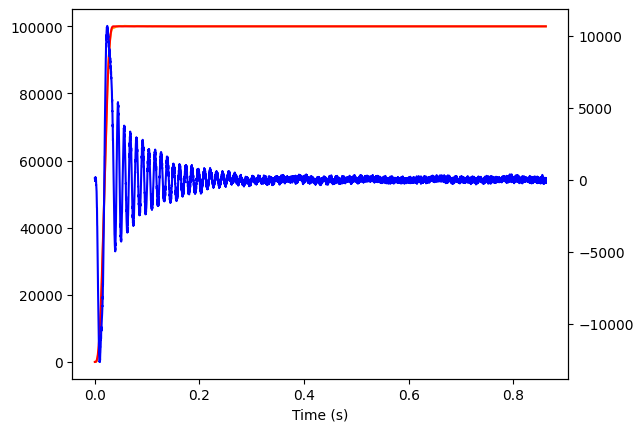

In [76]:
#plot of encoder position, command position, and endpoint acceleration vs time

#encoder position value of 1000000 is equivelent to 0.5 mm, (500um), so its a rise to 0.5 mm, a wait, and then a fall back to 0

fix, ax1 = plt.subplots()

ax2 = ax1.twinx()


ax1.plot(data.index.values / 8000, data["ENC_POS_FLOATMAG_BH"].values, "orange", label = "ENC_POS_FLOATMAG_BH")
ax1.plot(data.index.values / 8000, data["CMD_POS_FLOATMAG_BH"].values, "r", label = "CMD_POS_FLOATMAG_BH")
ax2.plot(data.index.values / 8000, data["FLOATMAG_ACC_ADC_PORT_0"].values, "b", label = "FLOATMAG_ACC_ADC_PORT_0")


ax1.set_xlabel('Time (s)')



Text(0, 0.5, 'functional point position')

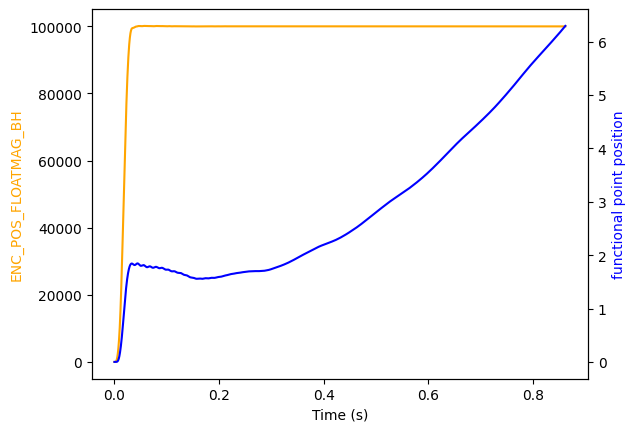

In [77]:
#plot of encoder position and endpoint position (by trapz integration of endpoint acceleration) vs time

#clearly a drift in the endpoint position, which is caused likely by sensor error
#so without some form of correction of this we are going to be unable to have a proper endpoint position reference

fix, ax1 = plt.subplots()

ax2 = ax1.twinx()

functional_point_velocity = (-data["FLOATMAG_ACC_ADC_PORT_0"]).expanding().apply(lambda x: np.trapz(x, dx=1/8000))
functional_point_position = (functional_point_velocity).expanding().apply(lambda x: np.trapz(x, dx=1/8000)).values #multiplying by 269.4 to convert to um (on the assumption that max position is 500 um)

ax1.plot(data.index.values / 8000, data["ENC_POS_FLOATMAG_BH"].values, "orange")
ax2.plot(data.index.values / 8000, functional_point_position, "b")



ax1.set_xlabel('Time (s)')
ax1.set_ylabel('ENC_POS_FLOATMAG_BH', color='orange')
ax2.set_ylabel('functional point position', color='b')


Text(0, 0.5, 'Functional point acceleration')

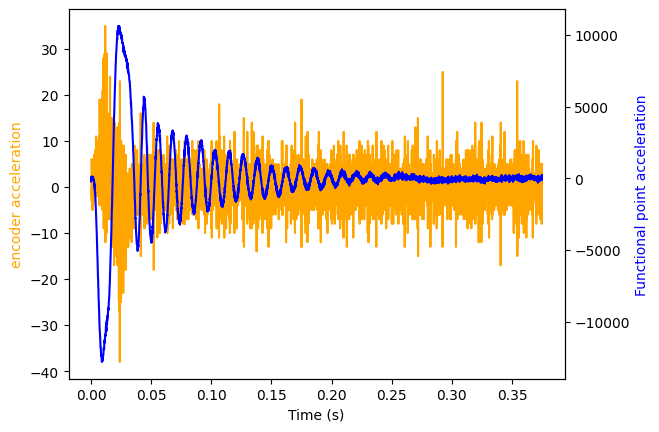

In [70]:
# plot of encoder acceleration and endpoint acceleration vs time

#

fix, ax1 = plt.subplots()

ax2 = ax1.twinx()

encoder_acceleration = data["ENC_POS_FLOATMAG_BH"].diff().diff()

ax1.plot(data.index.values[:3000] / 8000, encoder_acceleration.values[:3000], "orange")
ax2.plot(data.index.values[:3000] / 8000, data["FLOATMAG_ACC_ADC_PORT_0"].values[:3000], "b")


ax1.set_xlabel('Time (s)')
ax1.set_ylabel('encoder acceleration', color='orange')
ax2.set_ylabel('Functional point acceleration', color='b')


Text(0, 0.5, 'functional point position')

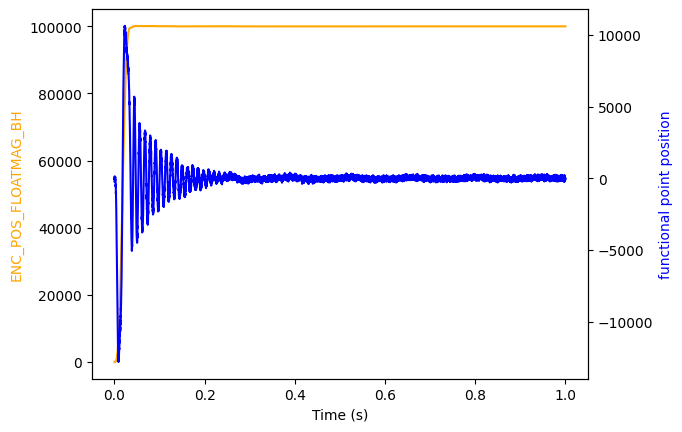

In [81]:
#lets get a closer view of the data:

#so a time range of 0.05 is all it takes for the current motion profile to reach the max position from start
time_range = 1


fix, ax1 = plt.subplots()

ax2 = ax1.twinx()

functional_point_position = (-data["FLOATMAG_ACC_ADC_PORT_0"]).expanding().apply(lambda x: np.trapz(x, dx=1/8000)).values

ax1.plot(data.index.values[:int(time_range * 8000)] / 8000, data["ENC_POS_FLOATMAG_BH"].values[:int(time_range * 8000)], "orange")
ax2.plot(data.index.values[:int(time_range * 8000)] / 8000, data["FLOATMAG_ACC_ADC_PORT_0"].values[:int(time_range * 8000)], "b")



ax1.set_xlabel('Time (s)')
ax1.set_ylabel('ENC_POS_FLOATMAG_BH', color='orange')
ax2.set_ylabel('functional point position', color='b')

In [82]:
0.4 * 8000

3200.0

Text(0, 0.5, 'functional point position')

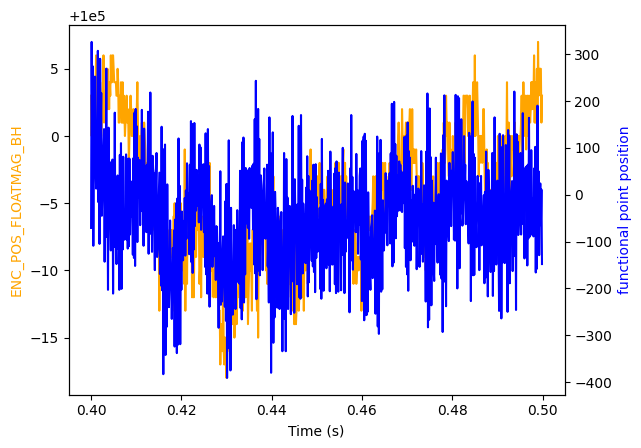

In [84]:
#wanted a view of the data from 0.4 to 0.5 seconds
#basically all of the data is relevant, dont have to segment the datasets

fix, ax1 = plt.subplots()

ax2 = ax1.twinx()

functional_point_position = (-data["FLOATMAG_ACC_ADC_PORT_0"]).expanding().apply(lambda x: np.trapz(x, dx=1/8000)).values

ax1.plot(data.index.values[3200:4000] / 8000, data["ENC_POS_FLOATMAG_BH"].values[3200:4000], "orange")
ax2.plot(data.index.values[3200:4000] / 8000, data["FLOATMAG_ACC_ADC_PORT_0"].values[3200:4000], "b")



ax1.set_xlabel('Time (s)')
ax1.set_ylabel('ENC_POS_FLOATMAG_BH', color='orange')
ax2.set_ylabel('functional point position', color='b')

In [10]:
24/ 30

0.8

In [7]:
np.random.choice(np.arange(0, 31), 10, replace=False)

array([ 8,  2, 23, 11, 24, 17, 18,  5, 16, 20])

In [13]:
train_file_indexes = np.random.choice(np.arange(0, 30), 24, replace=False)

In [14]:
np.sort(train_file_indexes)

array([ 0,  2,  4,  5,  6,  7,  8, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 23, 24, 27, 28, 29])

In [15]:
data = pd.read_csv(f'Data/FLOATMAG_BH_Datalog_2023_10_17 09.37.30 _Samp=8000/{filenames[0]}', delimiter="\t")

In [16]:
data

,sample,CMD_POS_FLOATMAG_BH,ENC_POS_FLOATMAG_BH,POS_ERR_FLOATMAG_BH,DAC_FLOATMAG_BH,MODE_FLOATMAG_BH,FLOATMAG_ACC_ADC_PORT_0
0,0,-3.0,-3.0,0.0,-203.0,ff010001,-125.0
1,1,-3.0,-2.0,-1.0,-209.0,ff010001,190.0
2,2,-3.0,-2.0,-1.0,-206.0,903000a,-77.0
3,3,-3.0,-4.0,1.0,-182.0,903000a,95.0
4,4,-3.0,-1.0,-2.0,-191.0,903000a,-97.0
...,...,...,...,...,...,...,...
2347,2347,99997.0,99987.0,10.0,263.0,ff010001,-169.0
2348,2348,99997.0,99984.0,13.0,274.0,ff010001,-64.0
2349,2349,99997.0,99984.0,13.0,263.0,ff010001,-173.0
2350,2350,99997.0,99984.0,13.0,261.0,ff010001,35.0


In [4]:
import os
import pandas as pd

#30 total
#24 for training
#6 for testing

filenames = [i for i in os.listdir('Data/FLOATMAG_BH_Datalog_2023_10_17 09.37.30 _Samp=8000/') if i.endswith(".dat")]

train_data = pd.DataFrame()

train_file_indexes = np.sort(np.random.choice(np.arange(0, 30), 24, replace=False))

print(f"train_file_indexes: {train_file_indexes}")

test_file_indexes = np.sort(np.array([i for i in np.arange(0, 30) if i not in train_file_indexes]))

print(f"test_file_indexes: {test_file_indexes}")

for i in train_file_indexes:

    data = pd.read_csv(f'Data/FLOATMAG_BH_Datalog_2023_10_17 09.37.30 _Samp=8000/{filenames[i]}', delimiter="\t")

    #enc position first and second derivatives
    data["dENC_X"] = data["ENC_POS_FLOATMAG_BH"].diff()
    data["ddENC_X"] = data["dENC_X"].diff()

    #adding rolling mean, var and slope features for encoder position
    data['rolling_mean_ENC_POS_10'] = data['ENC_POS_FLOATMAG_BH'].rolling(window=10).mean()
    data['rolling_var_ENC_POS_10'] = data['ENC_POS_FLOATMAG_BH'].rolling(window=10).var()
    data['rolling_slope_ENC_POS_10'] = data["ENC_POS_FLOATMAG_BH"].rolling(window = 10).apply(lambda x: np.polyfit(np.arange(len(x)), x, 1)[0], raw=True)

    data['rolling_mean_ENC_POS_30'] = data['ENC_POS_FLOATMAG_BH'].rolling(window=30).mean()
    data['rolling_var_ENC_POS_30'] = data['ENC_POS_FLOATMAG_BH'].rolling(window=30).var()
    data['rolling_slope_ENC_POS_30'] = data["ENC_POS_FLOATMAG_BH"].rolling(window = 30).apply(lambda x: np.polyfit(np.arange(len(x)), x, 1)[0], raw=True)

    data['rolling_mean_ENC_POS_50'] = data['ENC_POS_FLOATMAG_BH'].rolling(window=50).mean()
    data['rolling_var_ENC_POS_50'] = data['ENC_POS_FLOATMAG_BH'].rolling(window=50).var()
    data['rolling_slope_ENC_POS_50'] = data["ENC_POS_FLOATMAG_BH"].rolling(window = 50).apply(lambda x: np.polyfit(np.arange(len(x)), x, 1)[0], raw=True)

    enc_derivative_columns = ["dENC_X", "ddENC_X", "rolling_mean_ENC_POS_10", "rolling_var_ENC_POS_10", "rolling_slope_ENC_POS_10", "rolling_mean_ENC_POS_30", "rolling_var_ENC_POS_30", "rolling_slope_ENC_POS_30", "rolling_mean_ENC_POS_50", "rolling_var_ENC_POS_50", "rolling_slope_ENC_POS_50"]

    #now for the dac values:
    data["dDAC"] = data["DAC_FLOATMAG_BH"].diff()
    data["ddDAC"] = data["dDAC"].diff()

    data['rolling_mean_DAC_10'] = data['DAC_FLOATMAG_BH'].rolling(window=10).mean()
    data['rolling_var_DAC_10'] = data['DAC_FLOATMAG_BH'].rolling(window=10).var()
    data['rolling_slope_DAC_10'] = data["DAC_FLOATMAG_BH"].rolling(window = 10).apply(lambda x: np.polyfit(np.arange(len(x)), x, 1)[0], raw=True)

    data['rolling_mean_DAC_30'] = data['DAC_FLOATMAG_BH'].rolling(window=30).mean()
    data['rolling_var_DAC_30'] = data['DAC_FLOATMAG_BH'].rolling(window=30).var()
    data['rolling_slope_DAC_30'] = data["DAC_FLOATMAG_BH"].rolling(window = 30).apply(lambda x: np.polyfit(np.arange(len(x)), x, 1)[0], raw=True)

    data['rolling_mean_DAC_50'] = data['DAC_FLOATMAG_BH'].rolling(window=50).mean()
    data['rolling_var_DAC_50'] = data['DAC_FLOATMAG_BH'].rolling(window=50).var()
    data['rolling_slope_DAC_50'] = data["DAC_FLOATMAG_BH"].rolling(window = 50).apply(lambda x: np.polyfit(np.arange(len(x)), x, 1)[0], raw=True)

    dac_derivative_columns = ["dDAC", "ddDAC", "rolling_mean_DAC_10", "rolling_var_DAC_10", "rolling_slope_DAC_10", "rolling_mean_DAC_30", "rolling_var_DAC_30", "rolling_slope_DAC_30", "rolling_mean_DAC_50", "rolling_var_DAC_50", "rolling_slope_DAC_50"]


    #now for the position error values:
    data["dPOS_ERR"] = data["POS_ERR_FLOATMAG_BH"].diff()
    data["ddPOS_ERR"] = data["dPOS_ERR"].diff()

    data['rolling_mean_POS_ERR_10'] = data['POS_ERR_FLOATMAG_BH'].rolling(window=10).mean()
    data['rolling_var_POS_ERR_10'] = data['POS_ERR_FLOATMAG_BH'].rolling(window=10).var()
    data['rolling_slope_POS_ERR_10'] = data["POS_ERR_FLOATMAG_BH"].rolling(window = 10).apply(lambda x: np.polyfit(np.arange(len(x)), x, 1)[0], raw=True)

    data['rolling_mean_POS_ERR_30'] = data['POS_ERR_FLOATMAG_BH'].rolling(window=30).mean()
    data['rolling_var_POS_ERR_30'] = data['POS_ERR_FLOATMAG_BH'].rolling(window=30).var()
    data['rolling_slope_POS_ERR_30'] = data["POS_ERR_FLOATMAG_BH"].rolling(window = 30).apply(lambda x: np.polyfit(np.arange(len(x)), x, 1)[0], raw=True)

    data['rolling_mean_POS_ERR_50'] = data['POS_ERR_FLOATMAG_BH'].rolling(window=50).mean()
    data['rolling_var_POS_ERR_50'] = data['POS_ERR_FLOATMAG_BH'].rolling(window=50).var()
    data['rolling_slope_POS_ERR_50'] = data["POS_ERR_FLOATMAG_BH"].rolling(window = 50).apply(lambda x: np.polyfit(np.arange(len(x)), x, 1)[0], raw=True)

    pos_err_derivative_columns = ["dPOS_ERR", "ddPOS_ERR", "rolling_mean_POS_ERR_10", "rolling_var_POS_ERR_10", "rolling_slope_POS_ERR_10", "rolling_mean_POS_ERR_30", "rolling_var_POS_ERR_30", "rolling_slope_POS_ERR_30", "rolling_mean_POS_ERR_50", "rolling_var_POS_ERR_50", "rolling_slope_POS_ERR_50"]

    columns = ["sample", "CMD_POS_FLOATMAG_BH", "ENC_POS_FLOATMAG_BH", "POS_ERR_FLOATMAG_BH", "DAC_FLOATMAG_BH", "FLOATMAG_ACC_ADC_PORT_0"]
    columns.extend(enc_derivative_columns)
    columns.extend(dac_derivative_columns)
    columns.extend(pos_err_derivative_columns)

    t_data = data[columns]
    t_data["file"] = i

    train_data = pd.concat([train_data, t_data])



test_data = pd.DataFrame()

for i in test_file_indexes:

    data = pd.read_csv(f'Data/FLOATMAG_BH_Datalog_2023_10_17 09.37.30 _Samp=8000/{filenames[i]}', delimiter="\t")

    #enc position first and second derivatives
    data["dENC_X"] = data["ENC_POS_FLOATMAG_BH"].diff()
    data["ddENC_X"] = data["dENC_X"].diff()

    #adding rolling mean, var and slope features for encoder position
    data['rolling_mean_ENC_POS_10'] = data['ENC_POS_FLOATMAG_BH'].rolling(window=10).mean()
    data['rolling_var_ENC_POS_10'] = data['ENC_POS_FLOATMAG_BH'].rolling(window=10).var()
    data['rolling_slope_ENC_POS_10'] = data["ENC_POS_FLOATMAG_BH"].rolling(window = 10).apply(lambda x: np.polyfit(np.arange(len(x)), x, 1)[0], raw=True)

    data['rolling_mean_ENC_POS_30'] = data['ENC_POS_FLOATMAG_BH'].rolling(window=30).mean()
    data['rolling_var_ENC_POS_30'] = data['ENC_POS_FLOATMAG_BH'].rolling(window=30).var()
    data['rolling_slope_ENC_POS_30'] = data["ENC_POS_FLOATMAG_BH"].rolling(window = 30).apply(lambda x: np.polyfit(np.arange(len(x)), x, 1)[0], raw=True)

    data['rolling_mean_ENC_POS_50'] = data['ENC_POS_FLOATMAG_BH'].rolling(window=50).mean()
    data['rolling_var_ENC_POS_50'] = data['ENC_POS_FLOATMAG_BH'].rolling(window=50).var()
    data['rolling_slope_ENC_POS_50'] = data["ENC_POS_FLOATMAG_BH"].rolling(window = 50).apply(lambda x: np.polyfit(np.arange(len(x)), x, 1)[0], raw=True)

    enc_derivative_columns = ["dENC_X", "ddENC_X", "rolling_mean_ENC_POS_10", "rolling_var_ENC_POS_10", "rolling_slope_ENC_POS_10", "rolling_mean_ENC_POS_30", "rolling_var_ENC_POS_30", "rolling_slope_ENC_POS_30", "rolling_mean_ENC_POS_50", "rolling_var_ENC_POS_50", "rolling_slope_ENC_POS_50"]

    #now for the dac values:
    data["dDAC"] = data["DAC_FLOATMAG_BH"].diff()
    data["ddDAC"] = data["dDAC"].diff()

    data['rolling_mean_DAC_10'] = data['DAC_FLOATMAG_BH'].rolling(window=10).mean()
    data['rolling_var_DAC_10'] = data['DAC_FLOATMAG_BH'].rolling(window=10).var()
    data['rolling_slope_DAC_10'] = data["DAC_FLOATMAG_BH"].rolling(window = 10).apply(lambda x: np.polyfit(np.arange(len(x)), x, 1)[0], raw=True)

    data['rolling_mean_DAC_30'] = data['DAC_FLOATMAG_BH'].rolling(window=30).mean()
    data['rolling_var_DAC_30'] = data['DAC_FLOATMAG_BH'].rolling(window=30).var()
    data['rolling_slope_DAC_30'] = data["DAC_FLOATMAG_BH"].rolling(window = 30).apply(lambda x: np.polyfit(np.arange(len(x)), x, 1)[0], raw=True)

    data['rolling_mean_DAC_50'] = data['DAC_FLOATMAG_BH'].rolling(window=50).mean()
    data['rolling_var_DAC_50'] = data['DAC_FLOATMAG_BH'].rolling(window=50).var()
    data['rolling_slope_DAC_50'] = data["DAC_FLOATMAG_BH"].rolling(window = 50).apply(lambda x: np.polyfit(np.arange(len(x)), x, 1)[0], raw=True)

    dac_derivative_columns = ["dDAC", "ddDAC", "rolling_mean_DAC_10", "rolling_var_DAC_10", "rolling_slope_DAC_10", "rolling_mean_DAC_30", "rolling_var_DAC_30", "rolling_slope_DAC_30", "rolling_mean_DAC_50", "rolling_var_DAC_50", "rolling_slope_DAC_50"]


    #now for the position error values:
    data["dPOS_ERR"] = data["POS_ERR_FLOATMAG_BH"].diff()
    data["ddPOS_ERR"] = data["dPOS_ERR"].diff()

    data['rolling_mean_POS_ERR_10'] = data['POS_ERR_FLOATMAG_BH'].rolling(window=10).mean()
    data['rolling_var_POS_ERR_10'] = data['POS_ERR_FLOATMAG_BH'].rolling(window=10).var()
    data['rolling_slope_POS_ERR_10'] = data["POS_ERR_FLOATMAG_BH"].rolling(window = 10).apply(lambda x: np.polyfit(np.arange(len(x)), x, 1)[0], raw=True)

    data['rolling_mean_POS_ERR_30'] = data['POS_ERR_FLOATMAG_BH'].rolling(window=30).mean()
    data['rolling_var_POS_ERR_30'] = data['POS_ERR_FLOATMAG_BH'].rolling(window=30).var()
    data['rolling_slope_POS_ERR_30'] = data["POS_ERR_FLOATMAG_BH"].rolling(window = 30).apply(lambda x: np.polyfit(np.arange(len(x)), x, 1)[0], raw=True)

    data['rolling_mean_POS_ERR_50'] = data['POS_ERR_FLOATMAG_BH'].rolling(window=50).mean()
    data['rolling_var_POS_ERR_50'] = data['POS_ERR_FLOATMAG_BH'].rolling(window=50).var()
    data['rolling_slope_POS_ERR_50'] = data["POS_ERR_FLOATMAG_BH"].rolling(window = 50).apply(lambda x: np.polyfit(np.arange(len(x)), x, 1)[0], raw=True)

    pos_err_derivative_columns = ["dPOS_ERR", "ddPOS_ERR", "rolling_mean_POS_ERR_10", "rolling_var_POS_ERR_10", "rolling_slope_POS_ERR_10", "rolling_mean_POS_ERR_30", "rolling_var_POS_ERR_30", "rolling_slope_POS_ERR_30", "rolling_mean_POS_ERR_50", "rolling_var_POS_ERR_50", "rolling_slope_POS_ERR_50"]

    columns = ["sample", "CMD_POS_FLOATMAG_BH", "ENC_POS_FLOATMAG_BH", "POS_ERR_FLOATMAG_BH", "DAC_FLOATMAG_BH", "FLOATMAG_ACC_ADC_PORT_0"]
    columns.extend(enc_derivative_columns)
    columns.extend(dac_derivative_columns)
    columns.extend(pos_err_derivative_columns)

    t_data = data[columns]
    t_data["file"] = i

    test_data = pd.concat([test_data, t_data])


train_data.to_csv("Data/train_data_new.csv", index = False)
test_data.to_csv("Data/test_data_new.csv", index = False)



    

train_file_indexes: [ 0  1  2  4  5  6  8  9 10 11 12 14 15 17 18 19 21 22 24 25 26 27 28 29]
test_file_indexes: [ 3  7 13 16 20 23]


In [ ]:
#ok so in order to achieve the projects objective we need to provide the dac signal that corrects for the endpoint vibrations

#questions:
#We only have endpoint acceleration, and I am not sure that by numerical integration, the endpoint position is accurate
#Given this, we are going to just try and predict the acceleration values for now.
#Ok so how do we go from predicted acceleration values to a dac signal?

#first thing is to figure out how off from the desired point the endpoint is. But what do we use as the reference for this? ie in a real situation, lets say we have our predicted endpoint acceleration, what do we compare this to?
#Ok assuming we have some sort of desired endpoint position/ acceleration, and we have a prediction of the actual position / acceleration, what do we do:
# - we need some sort of dac reference, how do we convert measurement error differences into dac signal? We need information on this
# - also currently what are the units for all of the columns? encoder position we know from before, but what about the acceleration and dac signal?

